# Exercise 8

## Car Price Prediction

Predict if the price of a car is low or high

In [89]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [92]:
data.shape

(13150, 10)

In [ ]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [38]:
import pandas as pd
import numpy as np

In [39]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [40]:
j = 1
print(X.columns[j])

Mileage


In [28]:
# Split the variable in num_ctp points
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [41]:
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)

In [42]:
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [43]:
k = 5
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [44]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [45]:
gini_l = gini(y_l)
gini_l

0.20562506325087826

In [46]:
gini_r = gini(y_r)
gini_r

0.3991431537249346

In [ ]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [51]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18496148274516044

In [52]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [53]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [55]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': -1,
  'n_samples': 8368,
  'gain': 0.0359166442135464},
 'sr': {'y_pred': 0,
  'y_prob': 0.12771739130434784,
  'level': 1,
  'split': -1,
  'n_samples': 4782,
  'gain': 0.04846022210319853}}

In [ ]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [58]:
data.head(2)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1


In [59]:
tree

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 8368,
  'gain': 0.0359166442135464,
  'sl': {'y_pred': 0,
   'y_prob': 0.3403880070546737,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 565,
   'gain': 0.06001982703810749,
   'sl': {'y_pred': 0,
    'y_prob': 0.058823529411764705,
    'level': 3,
    'split': -1,
    'n_samples': 151,
    'gain': 0.005661757290357922},
   'sr': {'y_pred': 0,
    'y_prob': 0.44471153846153844,
    'level': 3,
    'split': -1,
    'n_samples': 414,
    'gain': 0.030742158715547196}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8737988468930173,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 7803,
   'gain': 0.015250286354762527,
   'sl': {'y_pred': 1,
    'y_prob': 0.731399157697707,
    'level': 3,
    'split': -1,
    'n_samples': 2135,
    'ga

In [61]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [64]:
tree_predict(X, tree)

array([1., 1., 0., ..., 1., 1., 0.])

In [68]:
y_pred=tree_predict(X_test, tree)

In [69]:
#Obteniendo el Accuracy
from sklearn import metrics
metrics.accuracy_score(y_pred, y_test)

0.8619815668202765

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #7

Evaluate the accuracy on the testing set

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [ ]:
# look for: "Recursively grow the tree" in 04 Decision trees  (add iteration in j, and in split as above in same code)

In [70]:
data.head(2)

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

for f in range(1,10):
    clf = DecisionTreeClassifier(max_depth=None, max_features=f, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
    
# Max features hay que impletarlo a la forma de hacer los árboles de forma manual llamando a la función modificada de construcción de arbol de decision 
# que estamos haciendo

Text(0, 0.5, 'Accuracy')

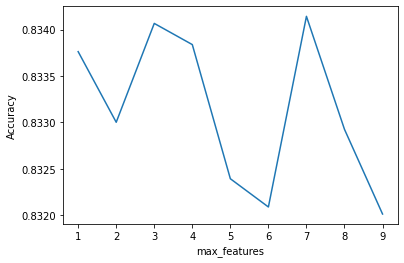

In [81]:
# plot max_depth (x-axis) versus RMSE (y-axis)
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

max_feature_range = range(1,10)
plt.plot(max_feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [80]:
accuracy_scores

[0.8337622150441636,
 0.8330017590342595,
 0.8340663975536693,
 0.8338382028861087,
 0.8323935094981569,
 0.8320892688514062,
 0.8341425589278147,
 0.8329255396108224,
 0.832013570376384]

In [78]:
f

9

# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [85]:
# set a seed for reproducibility
np.random.seed(123)

# Defidiendo el tamaño de los sampple (n_B)
n_samples = X_train.shape[0]
n_B = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [ ]:
# Haciendo el primer decision tree con  max_depth=None
from sklearn.tree import DecisionTreeClassifier
n_features=10
# grow each tree deep
treereg = DecisionTreeClassifier(max_depth=None, max_features = log(n_features), random_state=123) # ramdom state es la semilla

# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, 0:]
    y_train = y_train.iloc[sample, ]
    treereg.fit(X_train, y_train)
    y_pred[[i]] = treereg.predict(X_test)

In [87]:
n_B

10

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [88]:

from xgboost import XGBClassifier
clf = XGBClassifier()
clf

ModuleNotFoundError: No module named 'xgboost'

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set